# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import entropy
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, silhouette_score, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from collections import defaultdict
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

#Configuing pandas options so output cells aren't truncated
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000
pd.set_option('display.max_columns', 50)

# Loading data

In [ ]:
!curl -O https://raw.githubusercontent.com/rromer07/kickstarter-status-prediction/main/kickstarter_data_sampled_final.csv
resampled_df = pd.read_csv('kickstarter_data_sampled_final.csv',header=0)

# drop the ids and urls columns
resampled_df = resampled_df.drop(columns=['id_new', 'urls'])

# drop the 'garbage' rows
resampled_df = resampled_df.drop([0, 2340, 2341, 2342, 2466, 2467])

# fix the dtypes
dtypes = {'goal': float, 'disable_communication': bool, 'staff_pick': bool, 'backers_count': int, 'deadline_month': int, 'deadline_day': int, 'deadline_hr': int, 'state_changed_at_month': int, 'state_changed_at_day': int, 'state_changed_at_hr': int, 'created_at_month': int, 'created_at_day': int, 'created_at_hr': int, 'launched_at_month': int, 'launched_at_day': int, 'launched_at_hr': int, 'create_to_launch_days': int, 'launch_to_deadline_days': int, 'launch_to_state_change_days': int, 'SuccessfulBool': int, 'USorGB': int, 'TOPCOUNTRY': int, 'LaunchedTuesday': int, 'DeadlineWeekend': int}
resampled_df = resampled_df.astype(dtypes)

# dataframe with only numerical dtypes
resampled_numerical = resampled_df.select_dtypes(include=['int64','float64'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9812k  100 9812k    0     0  18.8M      0 --:--:-- --:--:-- --:--:-- 18.7M


In [ ]:
resampled_df.head()

,slug,created_at_month,launch_to_state_change,LaunchedTuesday,goal,create_to_launch,created_at_hr,deadline,state_changed_at_month,deadline_weekday,created_at,category,backers_count,create_to_launch_days,deadline_hr,state_changed_at_hr,country,deadline_month,staff_pick,blurb,launch_to_state_change_days,created_at_weekday,launched_at_weekday,launched_at_day,name,disable_communication,state_changed_at,USorGB,TOPCOUNTRY,launched_at_month,launch_to_deadline,deadline_day,launched_at,DeadlineWeekend,state_changed_at_weekday,state_changed_at_day,launch_to_deadline_days,SuccessfulBool,created_at_day,launched_at_hr,additional description
1,the-nan-no-ad-network,2,30 days 00:00:01.000000000,1,50000.0,4 days 09:35:18.000000000,2,3/12/15 12:22,3,Thursday,2/6/15 2:46,Web,1,4,12,12,US,3,True,A non-profit network organization\nfocused on ...,30,Friday,Tuesday,10,The NAN - No Ad Network,True,3/12/15 12:22,1,1,2,30 days 00:00:00.000000000,12,2/10/15 12:22,0,Thursday,12,30,0,6,12,NaN
2,mister-halo-a-c-misting-system,7,45 days 05:06:24.000000000,0,33000.0,64 days 18:53:18.000000000,17,10/25/14 17:48,10,Saturday,7/7/14 17:48,Gadgets,11,64,17,17,US,10,True,"A patent pending, energy saving misting system...",45,Monday,Wednesday,10,Mister Halo A/C misting system,True,10/25/14 17:48,1,1,9,45 days 05:06:24.000000000,25,9/10/14 12:41,1,Saturday,25,45,0,7,12,We are raising funds to pay a willing and able...
3,howcomo-action-sports-learn-share-and-get-spon...,7,2 days 18:47:14.000000000,1,200000.0,33 days 05:48:11.000000000,12,9/13/16 17:54,8,Tuesday,7/14/16 12:06,Web,6,33,17,12,US,9,True,HowComo is the only online action sports commu...,2,Thursday,Tuesday,16,"HowComo Action Sports | Learn, Share & Get Spo...",True,8/19/16 12:41,1,1,8,28 days 00:00:00.000000000,13,8/16/16 17:54,0,Friday,19,28,0,14,17,HowComo The first online application bringing ...
4,your-online-action-buddy-to-help-you-get-thing...,3,30 days 00:00:02.000000000,0,38000.0,17 days 18:31:56.000000000,1,5/14/16 20:15,5,Saturday,3/28/16 1:43,Web,2,17,20,20,AU,5,True,An online Productivity Partner to help you sta...,30,Monday,Thursday,14,Your Online Action Buddy to help you get thing...,True,5/14/16 20:15,0,0,4,30 days 00:00:00.000000000,14,4/14/16 20:15,1,Saturday,14,30,0,28,20,The Concept: Your Action Buddy. Your online p...
5,omnimark-led-light-bulbs-the-green-economical-...,11,30 days 00:00:00.000000000,1,5000.0,232 days 10:29:15.000000000,3,7/23/15 14:01,7,Thursday,11/3/14 3:32,Hardware,7,232,14,14,US,7,True,"Omnimark LED, a manufacturer of LED light bulb...",30,Monday,Tuesday,23,Omnimark LED Light Bulbs: The Green Economical...,True,7/23/15 14:01,1,1,6,30 days 00:00:00.000000000,23,6/23/15 14:01,0,Thursday,23,30,0,3,14,When inefficient traditional incandescent ligh...


# Helper functions

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(embedding, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init=10).fit(embedding)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(embedding)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(embedding.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (embedding[i, 0] - curr_center[0]) ** 2 + (embedding[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

def calculate_silhouette(embedding, kmax):
  sil = []
  # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init=10).fit(embedding)
    labels = kmeans.labels_
    sil.append(silhouette_score(embedding, labels, metric = 'euclidean'))
  return sil

# more info on clustering performance evaluation: https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
def fit_and_evaluate(km, X, y, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    labels = y
    evaluations = []
    evaluations_std = []
    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# Preprocessing

## Word Embeddings
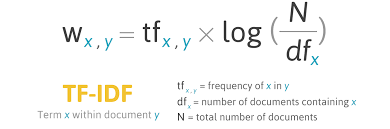

 Compute tf.idf for the three documents.
- D1: New York Tech 
- D2: New York City City Tech
- D3: City Tech New Tech

TF

| document | New | York | City | Tech |
| -------- | --- | ---- | ---- | ---- |
| D1 | 1 | 1 | 0 | 1 |
| D2 | 1/2 | 1/2 | 1/2 | 1/2 |
| D3 | 1/2 | 0 | 1/2 | 1 |


Query: city new tech york

IDF = log(N/df) - > N=3 

| word | idf |
| :---: | :---: |
|city | log(3/2 |
| new | 0 |
| tech | 0 |
| york | log(3/2) |

TF.IDF

| document | city | new | tech | york |
| -------- | ---- | --- | ---- | ---- |
| D1 | 0 | 0 | 0 | log(1.5) |
| D2 | log(1.5) | 0 | 0 | 0.5log(1.5) |
| D3 | 0.5log(1.5) | 0 | 0 | 0 | 

In [ ]:
"""
Topic extraction with Non-negative Matrix Factorization and Latent Direchlet 
Allocation. 

Code sample provided by scikit-learn: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
Info on Non-Negative Matrix Factorization (NMF): https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF
Info on Latent Dirichlet allocation: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
Info on loss fnt. Frobenius Norm: https://mathworld.wolfram.com/FrobeniusNorm.html
Info on loss fnt. Kullback-Leibler divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

"""

# Replacing NaN values with empty string
# resampled_df['combined_text_data'] = resampled_df['additional description'].fillna('')
# resampled_df['slug'] = resampled_df['slug'].fillna('')
# resampled_df['blurb'] = resampled_df['blurb'].fillna('')
# resampled_df['name'] = resampled_df['name'].fillna('')

resampled_df['combined_text_data'] = resampled_df['additional description'].fillna('') + ' ' + \
                               resampled_df['slug'].fillna('') + ' ' + \
                               resampled_df['blurb'].fillna('') + ' ' + \
                               resampled_df['name'].fillna('')



# Successful and unsuccesful projects
grouped_data = resampled_df.groupby('SuccessfulBool')
unsuccessful_df = grouped_data.get_group(0)
successful_df = grouped_data.get_group(1)

# Initializing TFIDF 
print('Extracting tf-idf features for NMF')
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, # ignore terms that appear in more than 90% of the documents
                                   min_df=5,    # ignore terms that are not present in at least 5 documents
                                   #max_features=n_features, 
                                   encoding='utf-8', 
                                   stop_words='english', 
                                   strip_accents='unicode')

tfidf_vectorizer_unsuc = TfidfVectorizer(max_df=0.70, # ignore terms that appear in more than 70% of the documents
                                   min_df=2,    # ignore terms that are not present in at least 2 documents
                                   #max_features=n_features, 
                                   encoding='utf-8', 
                                   stop_words='english', 
                                   strip_accents='unicode')

tfidf_vectorizer_succ = TfidfVectorizer(max_df=0.70, # ignore terms that appear in more than 70% of the documents
                                   min_df=2,    # ignore terms that are not present in at least 2 documents
                                   #max_features=n_features, 
                                   encoding='utf-8', 
                                   stop_words='english', 
                                   strip_accents='unicode')


# Learn vocabulary and idf, returns document-term matrix
t0 = time()
X_desc = tfidf_vectorizer.fit_transform(resampled_df['combined_text_data'].values.astype('U'))
print("vectorization done in %0.3fs. " % (time() - t0))
print(f"n_samples: {X_desc.shape[0]}, n_features: {X_desc.shape[1]}")
print(f"Around {X_desc.nnz / np.prod(X_desc.shape):.3f}% of the entries in X_desc matrix are non-zero.\n")  # sparsity of the X_desc matrix as a fraction of non-zero entries divided by the total number of elements

t0 = time()
X_desc_unsuccessful = tfidf_vectorizer_unsuc.fit_transform(unsuccessful_df['combined_text_data'].values.astype('U'))
print("vectorization done in %0.3fs. " % (time() - t0))
print(f"n_samples: {X_desc_unsuccessful.shape[0]}, n_features: {X_desc_unsuccessful.shape[1]}")
print(f"Around {X_desc_unsuccessful.nnz / np.prod(X_desc_unsuccessful.shape):.3f}% of the entries in X_desc_unsuccessful matrix are non-zero.\n")  # sparsity of the X_desc_unsuccessful matrix as a fraction of non-zero entries divided by the total number of elements

t0 = time()
X_desc_successful = tfidf_vectorizer_succ.fit_transform(successful_df['combined_text_data'].values.astype('U'))
print("vectorization done in %0.3fs. " % (time() - t0))
print(f"n_samples: {X_desc_successful.shape[0]}, n_features: {X_desc_successful.shape[1]}")
print(f"Around {X_desc_successful.nnz / np.prod(X_desc_successful.shape):.3f}% of the entries in X_desc_successful matrix are non-zero.\n")  # sparsity of the X_desc_successful matrix as a fraction of non-zero entries divided by the total number of elements


print('Extracting term frequency features for LDA')
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                encoding='utf-8', 
                                stop_words="english", 
                                strip_accents='unicode')
t0 = time()
dtm_tf = tf_vectorizer.fit_transform(resampled_df['combined_text_data'].values.astype('U'))
print('done in %0.3fs.' % (time() - t0))
print(f"n_samples: {dtm_tf.shape[0]}, n_features: {dtm_tf.shape[1]}")

tf_vectorizer_unsuc = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                encoding='utf-8', 
                                stop_words="english", 
                                strip_accents='unicode')
t0 = time()
unsuccessful_tf = tf_vectorizer_unsuc.fit_transform(unsuccessful_df['combined_text_data'].values.astype('U'))
print('done in %0.3fs.' % (time() - t0))
print(f"n_samples: {unsuccessful_tf.shape[0]}, n_features: {unsuccessful_tf.shape[1]}")

tf_vectorizer_suc = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                encoding='utf-8', 
                                stop_words="english", 
                                strip_accents='unicode')
t0 = time()
successful_tf = tf_vectorizer_suc.fit_transform(successful_df['combined_text_data'].values.astype('U'))
print('done in %0.3fs.' % (time() - t0))
print(f"n_samples: {successful_tf.shape[0]}, n_features: {successful_tf.shape[1]}")

Extracting tf-idf features for NMF
vectorization done in 8.982s. 
n_samples: 2495, n_features: 10500
Around 0.016% of the entries in X_desc matrix are non-zero.

vectorization done in 4.940s. 
n_samples: 1250, n_features: 12436
Around 0.012% of the entries in X_desc_unsuccessful matrix are non-zero.

vectorization done in 11.862s. 
n_samples: 1245, n_features: 15858
Around 0.012% of the entries in X_desc_successful matrix are non-zero.

Extracting term frequency features for LDA
done in 11.520s.
n_samples: 2495, n_features: 20918
done in 3.121s.
n_samples: 1250, n_features: 12436
done in 4.898s.
n_samples: 1245, n_features: 15858


## Topic Modelling

In [ ]:
! pip install -q pyLDAvis # visualization tool for topic modelling
! pip install -q pandas==1.5.1 # reinstalling due to a weird bug caused by pyLDAvis: https://github.com/bmabey/pyLDAvis/issues/249

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have

In [ ]:
grid_params = {'n_components' : [3, 5, 7, 10, 13, 15, 17, 22]}
# LDA model for all projects 
lda = LatentDirichletAllocation()
lda_model = HalvingGridSearchCV(lda,param_grid=grid_params)
lda_model.fit(dtm_tf)
# Estimators for LDA model
lda_model_all = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model_all.perplexity(dtm_tf))

#LDA model for unsuccessful projects
lda_model = HalvingGridSearchCV(lda,param_grid=grid_params)
lda_model.fit(unsuccessful_tf)
# Estimators for LDA model
lda_model_unsuc = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model_unsuc.perplexity(unsuccessful_tf))

#LDA model for successful projects
lda_model = HalvingGridSearchCV(lda,param_grid=grid_params)
lda_model.fit(successful_tf)
# Estimators for LDA model
lda_model_suc = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model_suc.perplexity(successful_tf))

Best LDA model's params {'n_components': 3}
Best log likelihood Score for the LDA model -1303316.0593131457
LDA model Perplexity on train data 4405.649532534339
Best LDA model's params {'n_components': 3}
Best log likelihood Score for the LDA model -539527.3654522671
LDA model Perplexity on train data 3845.8267762889523
Best LDA model's params {'n_components': 3}
Best log likelihood Score for the LDA model -745233.822466803
LDA model Perplexity on train data 4062.2196994414985


In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()  

#Visualize topic modelling for all projects
pyLDAvis.lda_model.prepare(lda_model_all, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.031625  0.079149       1        1  37.723568
2     -0.119795 -0.053418       2        1  36.735513
1      0.151419 -0.025731       3        1  25.540919, topic_info=                  Term         Freq        Total Category  logprob  loglift
18737          theatre  1099.000000  1099.000000  Default  30.0000  30.0000
1600               app  2378.000000  2378.000000  Default  29.0000  29.0000
19817              usb   964.000000   964.000000  Default  28.0000  28.0000
14065             play  1266.000000  1266.000000  Default  27.0000  27.0000
12468          musical   606.000000   606.000000  Default  26.0000  26.0000
18735          theater   501.000000   501.000000  Default  25.0000  25.0000
13914               pi   660.000000   660.000000  Default  24.0000  24.0000
1710           arduino   658.000000   658.000000  Default  23.0000  23.0000
12687              new  3148.000000  3148.000000  Default  22.0000  22.0000
7469          festival   468.000000   468.000000  Default  21.0000  21.0000
2685             board   937.000000   937.000000  Default  20.0000  20.0000
5125              data  1271.000000  1271.000000  Default  19.0000  19.0000
14349            power  1482.000000  1482.000000  Default  18.0000  18.0000
18018         students   579.000000   579.000000  Default  17.0000  17.0000
5551            device  1220.000000  1220.000000  Default  16.0000  16.0000
9046              help  2812.000000  2812.000000  Default  15.0000  15.0000
4554           control  1099.000000  1099.000000  Default  14.0000  14.0000
5552           devices   862.000000   862.000000  Default  13.0000  13.0000
2303           battery   913.000000   913.000000  Default  12.0000  12.0000
8873          hardware   677.000000   677.000000  Default  11.0000  11.0000
457                 3d   629.000000   629.000000  Default  10.0000  10.0000
17896            story   631.000000   631.000000  Default   9.0000   9.0000
16437           school   546.000000   546.000000  Default   8.0000   8.0000
12466            music   977.000000   977.000000  Default   7.0000   7.0000
4557        controller   457.000000   457.000000  Default   6.0000   6.0000
17689            stage   526.000000   526.000000  Default   5.0000   5.0000
10621              kit   548.000000   548.000000  Default   4.0000   4.0000
15132        raspberry   447.000000   447.000000  Default   3.0000   3.0000
1783              arts   323.000000   323.000000  Default   2.0000   2.0000
13729           people  2219.000000  2219.000000  Default   1.0000   1.0000
7621           fitness   209.869178   210.516822   Topic1  -7.1721   0.9718
17218       smartwatch   112.051665   112.726939   Topic1  -7.7996   0.9689
19875           vachen    77.158131    77.803254   Topic1  -8.1727   0.9666
11349           lumin8    92.980631    93.764312   Topic1  -7.9862   0.9665
20124              vis    77.147450    77.802918   Topic1  -8.1728   0.9664
10309            jeane    66.185061    66.827032   Topic1  -8.3261   0.9652
2502              bibo    61.201313    61.837967   Topic1  -8.4044   0.9645
17918            strap    81.910715    82.784944   Topic1  -8.1129   0.9643
5918             ditto    59.201846    59.842153   Topic1  -8.4376   0.9641
7638              flag    57.193927    57.845782   Topic1  -8.4721   0.9636
11582           mapper    56.205080    56.848415   Topic1  -8.4895   0.9635
20024         veterans    64.083852    64.825637   Topic1  -8.3584   0.9634
2842          bracelet    58.169128    58.842907   Topic1  -8.4552   0.9634
12949              obd    55.169466    55.849292   Topic1  -8.5081   0.9626
7558           finclip    48.229289    48.865947   Topic1  -8.6426   0.9618
12275         monsieur    47.209475    47.867212   Topic1  -8.6640   0.9610
19458         typhonrt    45.227977    45.872146   Topic1  -8.7068   0.9607
14987             qube    46.206685    

In [ ]:
pyLDAvis.lda_model.prepare(lda_model_unsuc, unsuccessful_tf, tf_vectorizer_unsuc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.116163 -0.010603       1        1  49.247722
2      0.069631 -0.074681       2        1  28.302069
0      0.046533  0.085284       3        1  22.450209, topic_info=                  Term         Freq        Total Category  logprob  loglift
876                app  1196.000000  1196.000000  Default  30.0000  30.0000
10277           social   512.000000   512.000000  Default  29.0000  29.0000
12108            water   341.000000   341.000000  Default  28.0000  28.0000
2674        controller   194.000000   194.000000  Default  27.0000  27.0000
6521             light   391.000000   391.000000  Default  26.0000  26.0000
9901            sensor   197.000000   197.000000  Default  25.0000  25.0000
12145          website   662.000000   662.000000  Default  24.0000  24.0000
1521             board   305.000000   305.000000  Default  23.0000  23.0000
8480             power   518.000000   518.000000  Default  22.0000  22.0000
8651        production   484.000000   484.000000  Default  21.0000  21.0000
945            arduino   174.000000   174.000000  Default  20.0000  20.0000
208                 3d   277.000000   277.000000  Default  19.0000  19.0000
3286            device   553.000000   553.000000  Default  18.0000  18.0000
1312           battery   331.000000   331.000000  Default  17.0000  17.0000
3219            design   898.000000   898.000000  Default  16.0000  16.0000
11781              usb   294.000000   294.000000  Default  15.0000  15.0000
2671           control   427.000000   427.000000  Default  14.0000  14.0000
5261          hardware   244.000000   244.000000  Default  13.0000  13.0000
3942            energy   276.000000   276.000000  Default  12.0000  12.0000
9536             robot   163.000000   163.000000  Default  11.0000  11.0000
7365             music   388.000000   388.000000  Default  10.0000  10.0000
8306              play   443.000000   443.000000  Default   9.0000   9.0000
8764         prototype   433.000000   433.000000  Default   8.0000   8.0000
9902           sensors   150.000000   150.000000  Default   7.0000   7.0000
8650           product   589.000000   589.000000  Default   6.0000   6.0000
8098            people  1168.000000  1168.000000  Default   5.0000   5.0000
10232            smart   340.000000   340.000000  Default   4.0000   4.0000
12104            watch   225.000000   225.000000  Default   3.0000   3.0000
6962             media   345.000000   345.000000  Default   2.0000   2.0000
2638           content   253.000000   253.000000  Default   1.0000   1.0000
12146         websites    71.124868    71.792246   Topic1  -7.6424   0.6990
5956         interests    68.206767    68.881081   Topic1  -7.6843   0.6985
6861       marketplace    57.568256    58.207883   Topic1  -7.8538   0.6973
2201           clients    62.333298    63.058188   Topic1  -7.7743   0.6967
6838              maps    53.608119    54.324811   Topic1  -7.9251   0.6950
3015            dating    47.858319    48.504171   Topic1  -8.0386   0.6949
3872         emotional    45.913123    46.563343   Topic1  -8.0801   0.6942
8614           privacy    46.868305    47.533501   Topic1  -8.0595   0.6942
3751              edit    48.777254    49.473587   Topic1  -8.0195   0.6941
12033             vote    45.890678    46.563006   Topic1  -8.0805   0.6938
1504             bloom    47.768200    48.502183   Topic1  -8.0405   0.6931
1779            buyers    41.073203    41.711869   Topic1  -8.1915   0.6929
3874          emotions    40.100456    40.741480   Topic1  -8.2154   0.6924
7285         motivband    39.134819    39.771215   Topic1  -8.2398   0.6922
3548            domain    41.038307    41.711186   Topic1  -8.1923   0.6920
10755     subscription    43.893267    44.620724   Topic1  -8.1250   0.6919
2638           content   248.984063   253.160766   Topic1  -6.3894   0.6917
9871            selfie    49.607594    

In [ ]:
pyLDAvis.lda_model.prepare(lda_model_suc, successful_tf, tf_vectorizer_suc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.120500 -0.066097       1        1  50.494422
0      0.142716 -0.039387       2        1  28.828106
1     -0.022216  0.105484       3        1  20.677471, topic_info=                Term         Freq        Total Category  logprob  loglift
14224        theatre   948.000000   948.000000  Default  30.0000  30.0000
1195             app  1118.000000  1118.000000  Default  29.0000  29.0000
9452         musical   487.000000   487.000000  Default  28.0000  28.0000
10654           play   824.000000   824.000000  Default  27.0000  27.0000
6842            help  1581.000000  1581.000000  Default  26.0000  26.0000
14222        theater   407.000000   407.000000  Default  25.0000  25.0000
9607             new  2032.000000  2032.000000  Default  24.0000  24.0000
5651        festival   390.000000   390.000000  Default  23.0000  23.0000
15029            usb   677.000000   677.000000  Default  22.0000  22.0000
8089              la   301.000000   301.000000  Default  21.0000  21.0000
1750         battery   581.000000   581.000000  Default  20.0000  20.0000
4327        director   288.000000   288.000000  Default  19.0000  19.0000
13428          stage   354.000000   354.000000  Default  18.0000  18.0000
6056          fringe   269.000000   269.000000  Default  17.0000  17.0000
1277         arduino   489.000000   489.000000  Default  16.0000  16.0000
5214              et   199.000000   199.000000  Default  15.0000  15.0000
10536             pi   460.000000   460.000000  Default  14.0000  14.0000
1337         artists   271.000000   271.000000  Default  13.0000  13.0000
10396         people  1016.000000  1016.000000  Default  12.0000  12.0000
9250          mobile   446.000000   446.000000  Default  11.0000  11.0000
4195          device   661.000000   661.000000  Default  10.0000  10.0000
8245        learning   274.000000   274.000000  Default   9.0000   9.0000
4977              en   182.000000   182.000000  Default   8.0000   8.0000
1338            arts   250.000000   250.000000  Default   7.0000   7.0000
13593          story   455.000000   455.000000  Default   6.0000   6.0000
8241           learn   361.000000   361.000000  Default   5.0000   5.0000
4196         devices   534.000000   534.000000  Default   4.0000   4.0000
2556            cast   223.000000   223.000000  Default   3.0000   3.0000
2437          camera   504.000000   504.000000  Default   2.0000   2.0000
6711        hardware   435.000000   435.000000  Default   1.0000   1.0000
1277         arduino   488.860086   489.515983   Topic1  -6.0494   0.6820
10536             pi   459.338566   460.024151   Topic1  -6.1117   0.6818
11459      raspberry   323.730988   324.369423   Topic1  -6.4616   0.6813
10089         output   217.551755   218.202783   Topic1  -6.8591   0.6803
15029            usb   675.173142   677.214702   Topic1  -5.7265   0.6803
2701         charger   183.154138   183.797421   Topic1  -7.0312   0.6798
3437      controller   263.372118   264.389369   Topic1  -6.6679   0.6795
1748       batteries   149.728132   150.374620   Topic1  -7.2327   0.6790
9365           motor   142.829197   143.492747   Topic1  -7.2799   0.6787
10354            pcb   146.718239   147.423119   Topic1  -7.2530   0.6785
12899         signal   129.079938   129.731016   Topic1  -7.3811   0.6783
14674    triggertrap   118.289961   118.918739   Topic1  -7.4684   0.6780
5757        firmware   117.292057   117.935120   Topic1  -7.4768   0.6778
3311       connector   107.474443   108.105430   Topic1  -7.5643   0.6775
13163          solar   116.258815   116.950074   Topic1  -7.4857   0.6774
8260            leds   127.963198   128.742624   Topic1  -7.3898   0.6772
12705          setup   102.526421   103.189004   Topic1  -7.6114   0.6769
15310        voltage   149.334412   150.358798   Topic1  -7.2353   0.6765
13036          slide    94.673198    95.325289   Topic1  -7.6

## Categorical

In [ ]:
# deadline_weekday, category, country, staff_pick, created_at_weekday, launched_at_weekday, disable_communication, state_changed_at_weekday

In [ ]:
resampled_df['deadline_weekday'][0:10]

1      Thursday
2      Saturday
3       Tuesday
4      Saturday
5      Thursday
6      Thursday
7        Friday
8     Wednesday
9      Saturday
10       Monday
Name: deadline_weekday, dtype: object

## Date Time

In [ ]:
# launch_to_state_change?, create_to_launch?, deadline, created_at, state_changed_at, launch_to_deadline?, launched_at

# Train test split

In [ ]:
# Variable to predict 'y'
y = resampled_df['SuccessfulBool']
y.shape

(2495,)

In [ ]:
# train/test split for numerical data
X_numerical = resampled_numerical.drop(['SuccessfulBool'], axis=1)
X_train_numerical, X_test_numerical, y_train_numerical, y_test_numerical = train_test_split(X_numerical,y,test_size=0.2,random_state=0)
X_train_numerical.shape, X_test_numerical.shape, y_train_numerical.shape, y_test_numerical.shape

((1996, 21), (499, 21), (1996,), (499,))

In [ ]:
# train/test split for desecription data
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc,y,test_size=0.2,random_state=0)
X_train_desc.shape, X_test_desc.shape, y_train_desc.shape, y_test_desc.shape

((1996, 10500), (499, 10500), (1996,), (499,))

# Models 

#Naive Bayes
###Initialize Model

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_desc.toarray(), y_train_desc)
y_pred_prob_nb = gnb.predict_proba(X_test_desc.toarray())[:,1] # for ROC curve
y_pred_nb = gnb.predict(X_test_desc.toarray())
cm = confusion_matrix(y_test_desc, y_pred_nb)

###Evaluations

In [ ]:
accuracy = accuracy_score(y_test_desc, y_pred_nb)
class_acc = cm.diagonal()/cm.sum(axis=1)
print(f"Naive Bayes Accuracy: {accuracy*100:.3f}%")
print(f'Unsuccessful class accuracy {class_acc[0]*100:.3f}\nSuccessful class accuracy {class_acc[1]*100:.3f}\n')
print(classification_report(y_test_desc, y_pred_nb, target_names=['Unsuccessful', 'Successful'], digits=4))

Naive Bayes Accuracy: 58.717%
Unsuccessful class accuracy 46.667
Successful class accuracy 69.884

              precision    recall  f1-score   support

Unsuccessful     0.5895    0.4667    0.5209       240
  Successful     0.5858    0.6988    0.6373       259

    accuracy                         0.5872       499
   macro avg     0.5876    0.5828    0.5791       499
weighted avg     0.5875    0.5872    0.5813       499



Text(0.5, 1.0, 'Confusion Matrix')

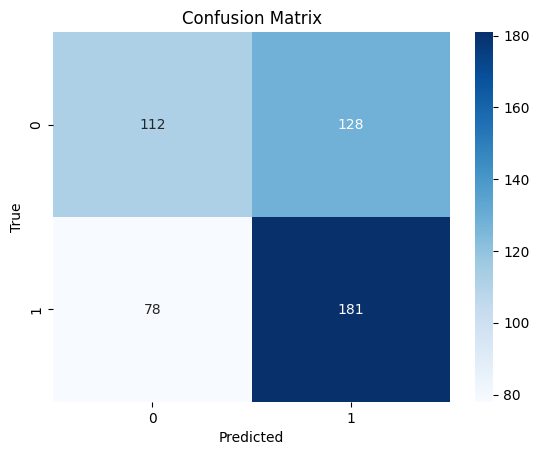

In [ ]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#Complement Naive Bayes
###Initialize Model

In [ ]:
cnb = ComplementNB()
cnb.fit(X_train_desc.toarray(), y_train_desc)
y_pred_prob_cnb = cnb.predict_proba(X_test_desc.toarray())[:,1] # for ROC curve
y_pred_cnb = cnb.predict(X_test_desc.toarray())
cm_cnb = confusion_matrix(y_test_desc, y_pred_cnb)

###Evaluations

In [ ]:
accuracy = accuracy_score(y_test_desc, y_pred_cnb)
class_acc = cm_cnb.diagonal()/cm_cnb.sum(axis=1)
print(f"Complement Naive Bayes Accuracy: {accuracy*100:.3f}%")
print(f'Unsuccessful class accuracy {class_acc[0]*100:.3f}\nSuccessful class accuracy {class_acc[1]*100:.3f}\n')
print(classification_report(y_test_desc, y_pred_cnb, target_names=['Unsuccessful', 'Successful'], digits=4))

Complement Naive Bayes Accuracy: 65.531%
Unsuccessful class accuracy 66.667
Successful class accuracy 64.479

              precision    recall  f1-score   support

Unsuccessful     0.6349    0.6667    0.6504       240
  Successful     0.6761    0.6448    0.6601       259

    accuracy                         0.6553       499
   macro avg     0.6555    0.6557    0.6552       499
weighted avg     0.6563    0.6553    0.6554       499



Text(0.5, 1.0, 'Confusion Matrix')

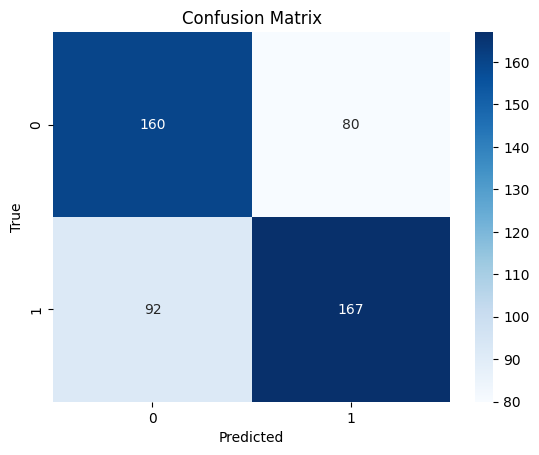

In [ ]:
sns.heatmap(cm_cnb, annot=True, cmap='Blues', fmt='g')

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#Support Vector Machines
## Hyperparameter Tunning
###Grid Search CV

In [ ]:
param_grid_SVC = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

# random_SVC = RandomizedSearchCV(SVC(), param_random_SVC,n_jobs=-1,verbose=0,random_state=222)
# random_SVC.fit(x_train, y_train)


grid_SVC = GridSearchCV(SVC(),param_grid_SVC,refit=True,verbose=3,n_jobs=-1)
grid_SVC.fit(X_train_desc.toarray(), y_train_desc)

In [ ]:
#SVC
print(grid_SVC.best_params_)
print(grid_SVC.best_estimator_)
grid_predictions_SVC = grid_SVC.predict(X_test_desc.toarray())
print(classification_report(y_test_desc, grid_predictions_SVC))
print('Best score for SVC: ',grid_SVC.best_score_)
print()

###Initialize Model

In [ ]:
clf = SVC(C=1, kernel='rbf', degree=3,gamma=1, probability=True)
clf.fit(X_train_desc.toarray(), y_train_desc)
y_pred_prob_svm = clf.predict_proba(X_test_desc.toarray())[:,1]
y_pred_svm = clf.predict(X_test_desc.toarray())
cm_svm = confusion_matrix(y_test_desc, y_pred_svm)

###Evaluations

In [ ]:
accuracy = accuracy_score(y_test_desc, y_pred_svm)
class_acc = cm_svm.diagonal()/cm_svm.sum(axis=1)
print(f"Support Vector Machine: {accuracy*100:.3f}%")
print(f'Unsuccessful class accuracy {class_acc[0]*100:.3f}\nSuccessful class accuracy {class_acc[1]*100:.3f}\n')
print(classification_report(y_test_desc, y_pred_svm, target_names=['Unsuccessful', 'Successful'], digits=4))

Support Vector Machine: 67.735%
Unsuccessful class accuracy 69.583
Successful class accuracy 66.023

              precision    recall  f1-score   support

Unsuccessful     0.6549    0.6958    0.6747       240
  Successful     0.7008    0.6602    0.6799       259

    accuracy                         0.6774       499
   macro avg     0.6779    0.6780    0.6773       499
weighted avg     0.6787    0.6774    0.6774       499



Text(0.5, 1.0, 'Confusion Matrix')

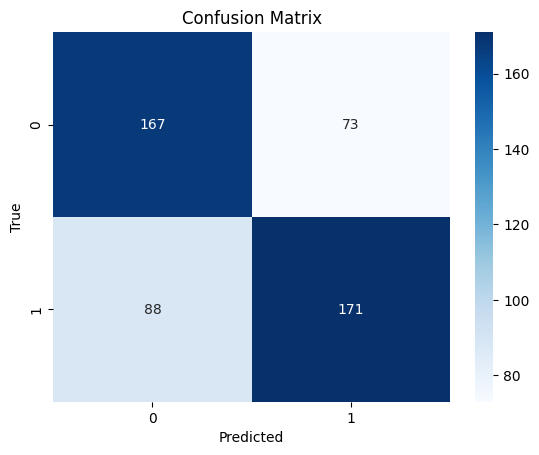

In [ ]:
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='g')

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#XGBoost 
##Hyperparameter Tuning
###Randomized Search CV

In [ ]:
# A parameter grid for XGBoost

param_grid_XGB = {
    'n_estimators': [300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb = XGBClassifier()

grid_XGB = RandomizedSearchCV(XGBClassifier(),param_grid_XGB,refit=True,verbose=3,n_jobs=-1)

t0 = time()
grid_XGB.fit(X_train_desc.toarray(), y_train_desc)
print(f"XGB Grid Search done in {time() - t0:.3f} s")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB Grid Search done in 7470.316 s


In [ ]:
#XGB
print(grid_XGB.best_params_)
print(grid_XGB.best_estimator_)
grid_predictions_XGB = grid_XGB.predict(X_test_desc.toarray())
print(classification_report(y_test_desc, grid_predictions_XGB))
print('Best score for XGB: ',grid_XGB.best_score_)
print()

{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       240
           1       0.72      0.6

###Initialize Model

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_desc.toarray(), y_train_desc)
y_pred_prob_xgb = xgb.predict_proba(X_test_desc.toarray())[:,1]
y_pred_xgb = clf.predict(X_test_desc.toarray())
cm_xgb = confusion_matrix(y_test_desc, y_pred_xgb)

###Evaluations

In [ ]:
accuracy = accuracy_score(y_test_desc, y_pred_xgb)
class_acc = cm_xgb.diagonal()/cm_xgb.sum(axis=1)
print(f"XGBOOST : {accuracy*100:.3f}%")
print(f'Unsuccessful class accuracy {class_acc[0]*100:.3f}\nSuccessful class accuracy {class_acc[1]*100:.3f}\n')
print(classification_report(y_test_desc, y_pred_xgb, target_names=['Unsuccessful', 'Successful'], digits=4))

XGBOOST : 67.735%
Unsuccessful class accuracy 69.583
Successful class accuracy 66.023

              precision    recall  f1-score   support

Unsuccessful     0.6549    0.6958    0.6747       240
  Successful     0.7008    0.6602    0.6799       259

    accuracy                         0.6774       499
   macro avg     0.6779    0.6780    0.6773       499
weighted avg     0.6787    0.6774    0.6774       499



Text(0.5, 1.0, 'Confusion Matrix')

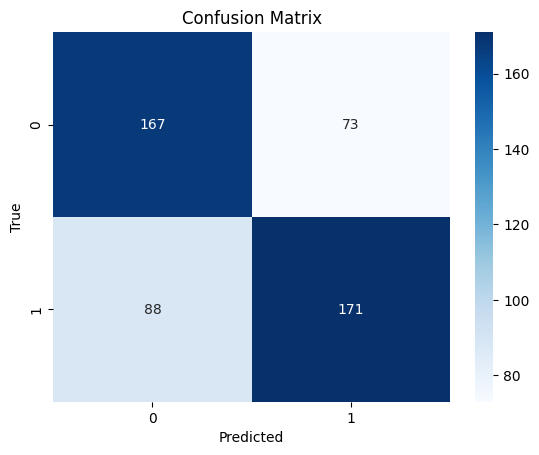

In [ ]:
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g')

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#Random Forest
##Hyperparamter Tunning
### Randomized Search CV

In [ ]:

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5,n_jobs = -1)

t0 = time()
# Fit the model to the data
grid_search_rf.fit(X_train_desc.toarray(), y_train_desc)
print(f"RF Randomized Search done in {time() - t0:.3f} s")

# Print the best parameters and score
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best Score: ", grid_search_rf.best_score_)

RF Randomized Search done in 2410.233 s
Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score:  0.7164423558897244


In [ ]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_estimator_)
grid_predictions_RF = grid_search_rf.predict(X_test_desc.toarray())
print(classification_report(y_test_desc, grid_predictions_RF))
print('Best score for Random Forest: ',grid_search_rf.best_score_)
print()

NameError: ignored

###Initialize Model

In [ ]:
rf = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=200)
rf.fit(X_train_desc.toarray(), y_train_desc)
y_pred_prob_rf = rf.predict_proba(X_test_desc.toarray())[:,1]
y_pred_rf = rf.predict(X_test_desc.toarray())
cm_rf = confusion_matrix(y_test_desc, y_pred_rf)

###Evaluations

In [ ]:
accuracy = accuracy_score(y_test_desc, y_pred_rf)
class_acc = cm_rf.diagonal()/cm_rf.sum(axis=1)
print(f"Random Forest Classifier: {accuracy*100:.3f}%")
print(f'Unsuccessful class accuracy: {class_acc[0]*100:.3f}\nSuccessful class accuracy: {class_acc[1]*100:.3f}\n')
print(classification_report(y_test_desc, y_pred_rf, target_names=['Unsuccessful', 'Successful'], digits=4))

Random Forest Classifier: 71.343%
Unsuccessful class accuracy: 70.833
Successful class accuracy: 71.815

              precision    recall  f1-score   support

Unsuccessful     0.6996    0.7083    0.7039       240
  Successful     0.7266    0.7181    0.7223       259

    accuracy                         0.7134       499
   macro avg     0.7131    0.7132    0.7131       499
weighted avg     0.7136    0.7134    0.7135       499



Text(0.5, 1.0, 'Confusion Matrix')

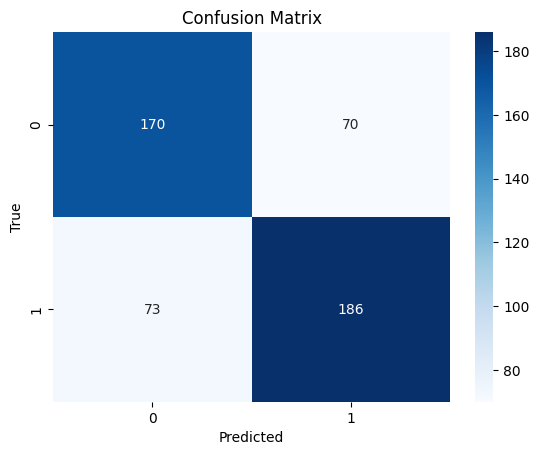

In [ ]:
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')

# add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

## Classifier comparison

###ROC Curve

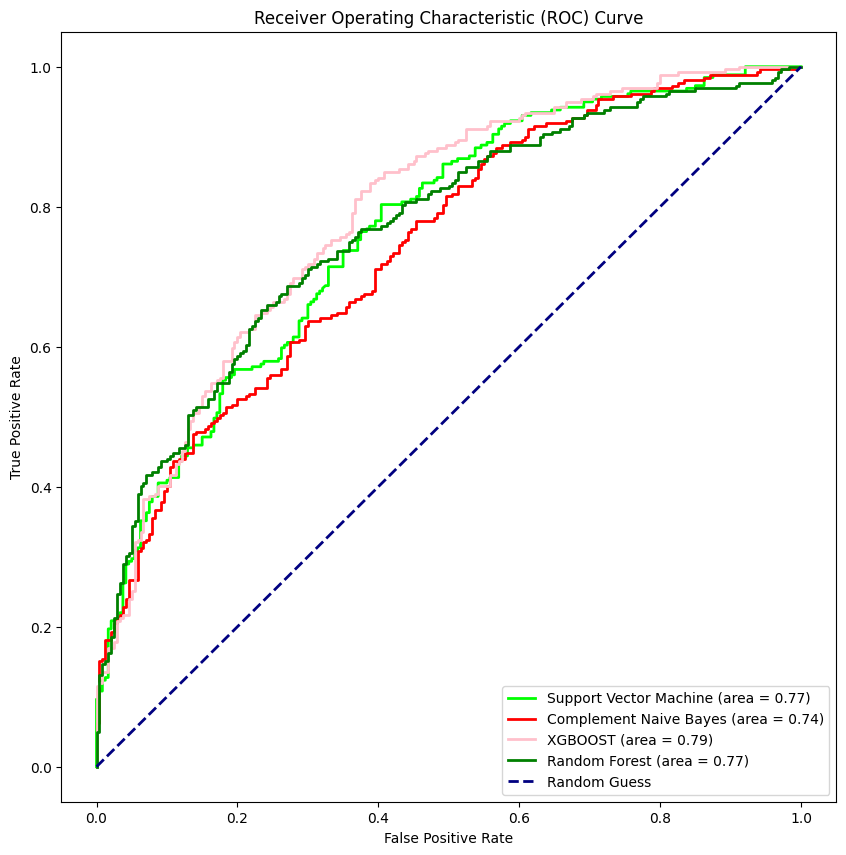

In [ ]:
fpr_svm, tpr_svm, thresholds = roc_curve(y_test_desc, y_pred_prob_svm)
fpr_cnb, tpr_cnb, thresholds = roc_curve(y_test_desc, y_pred_prob_cnb)
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test_desc, y_pred_prob_xgb)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test_desc, y_pred_prob_rf)

roc_auc_svm = auc(fpr_svm, tpr_svm)
roc_auc_cnb = auc(fpr_cnb, tpr_cnb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_svm, tpr_svm, color='lime', lw=2, label='Support Vector Machine (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_cnb, tpr_cnb, color='red', lw=2, label='Complement Naive Bayes (area = %0.2f)' % roc_auc_cnb)
plt.plot(fpr_xgb, tpr_xgb, color='pink', lw=2, label='XGBOOST (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (area = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

<Figure size 2700x900 with 0 Axes>

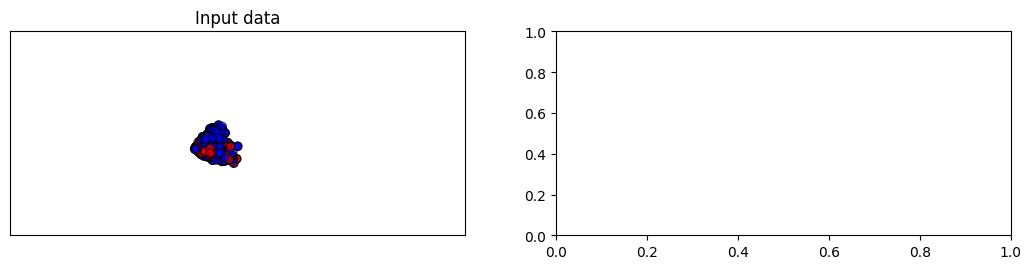

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train_desc)
X_test_svd = svd.fit_transform(X_test_desc)

X_desc_whole_svd = svd.fit_transform(X_desc)

figure = plt.figure(figsize=(27, 9))
names = ['Complement Naive Bayes', 'Support Vector Machines', 'Random Forest']
classifiers = [cnb, clf, rf]
i = 1
linearly_separable = (X_desc_whole_svd, y)
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_desc, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test_svd[:, 0], X_test_svd[:, 1], c=y_test_desc, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets),len(classifiers) + 1, i)
        clf = make_pipeline(StandardScaler(with_mean=False), clf)
        clf.fit(X_train_svd, y_train_desc)
        score = clf.score(X_test_svd, y_test_desc)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_test_svd, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])

        # Plot the training points
        ax.scatter(
            X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_desc, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test_svd[:, 0],
            X_test_svd[:, 1],
            c=y_test_desc,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('Complement Naive Bayes', cnb),('Random Forest',rf),('SVM RBF Kernel',clf ),('xgboost',xgb)], voting='soft')
ensemble.fit(X_train_desc.toarray(), y_train_desc)

ensemble_pred = ensemble.predict(X_test_desc.toarray())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

ensemble_acc = accuracy_score(y_test_desc, ensemble_pred)
ensemble_prec = precision_score(y_test_desc, ensemble_pred)
ensemble_rec = recall_score(y_test_desc, ensemble_pred)
ensemble_f1 = f1_score(y_test_desc, ensemble_pred)

print('Ensemble model accuracy:', ensemble_acc)
print('Ensemble model precision:', ensemble_prec)
print('Ensemble model recall:', ensemble_rec)
print('Ensemble model F1 score:', ensemble_f1)

In [ ]:
joblib.dump(ensemble, 'textual_ensemble.joblib')
joblib.dump(rf,'textual.joblib')

['textual.joblib']

In [ ]:
resampled_df['combined_text_data'] = resampled_df['additional description'].fillna('') + ' ' + \
                               resampled_df['slug'].fillna('') + ' ' + \
                               resampled_df['blurb'].fillna('') + ' ' + \
                               resampled_df['name'].fillna('')

In [ ]:
test_data = resampled_df.head()
# test_data['combined_text_data'] = test_data['additional description'].fillna('') + ' ' + \
                              #  test_data['slug'].fillna('') + ' ' + \
                              #  test_data['blurb'].fillna('') + ' ' + \
                              #  test_data['name'].fillna('')

X_test = tfidf_vectorizer.fit_transform(test_data['combined_text_data'].values.astype('U'))   

# X_test = tfidf_vectorizer.fit_transform(test_data)

ValueError: ignored

Ensemble model accuracy: 0.6993987975951904

Ensemble model precision: 0.7104247104247104

Ensemble model recall: 0.7104247104247104

Ensemble model F1 score: 0.7104247104247104